In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.lines as mlines
from scipy.interpolate import interp1d
from scipy.interpolate import griddata

$RMSD_{KLDiv}=\sqrt{\frac{\sum_{i}\left(\left(F-\left<F\right>\right)-\left(F_{ref}-\left<F_{ref}\right>\right)\right)^2 e^{-\beta F_{ref,i}} }{\sum_{i} e^{-\beta F_{ref,i}}}}$

$RMSD_{CUT}=\sqrt{\frac{\sum_{i}\left(\left(F-\left<F\right>\right)-\left(F_{ref}-\left<F_{ref}\right>\right)\right)^2 \theta\left(\nu-F_{ref} \right) }{\sum_{i} \theta\left(\nu-F_{ref} \right)}}$

In [2]:
def RMSDall(var,var2,kt,nu):
    #where var = current , var2 = ref  
    
    #NOTE --> THESE ARE ALIGNED ON MIN F NOT AVERAGE! THERE ARE ARTIFICIAL HIGH ENERGY STRUCTURES 
    # YOU CAN EASILY IMPLEMENT AN ALIGNMENT BASED ON AVG BELOW NU BUT DID NOT ...
    val1=0
    val2=0
    val3=0

    RMSDKl=0
    RMSDCut=0
    refmean=np.mean(var2)
    newmean=np.mean(var)
    (a,b)=np.shape(var2)
    
    #heavyside mean: 
    for i in np.arange(a):
        for j in np.arange(b):
            if (var2[i,j] < nu):
                val1=val1+var2[i,j]
                val2=val2+1
                val3=val3+var[i,j] # for current mean 
                
    refmeanH=val1/val2
    newmeanH=val3/val2
    val1=0
    val2=0
    val3=0
    
    for i in np.arange(a):
        for j in np.arange(b):
            RMSDKl=RMSDKl+np.power((var[i,j]-newmean)-(var2[i,j]-refmean),2)*np.exp(-var2[i,j]/kt)
            val1=val1+np.exp(-var2[i,j]/kt)
       
            if (var2[i,j] < nu):
                RMSDCut=RMSDCut + np.power((var[i,j]-newmeanH)-(var2[i,j]-refmeanH),2)
                val2=val2+1
                
            
    RMSDKl=np.sqrt(RMSDKl/val1)
    RMSDCut=np.sqrt(RMSDCut/val2)
  
    return [RMSDKl,RMSDCut]

In [3]:
def RMSDallnomean(var,var2,kt,nu):
    #where var = current , var2 = ref  
    
    #NOTE --> THESE ARE ALIGNED ON MIN F NOT AVERAGE! THERE ARE ARTIFICIAL HIGH ENERGY STRUCTURES 
    # YOU CAN EASILY IMPLEMENT AN ALIGNMENT BASED ON AVG BELOW NU BUT DID NOT ...
    val1=0
    val2=0
    RMSDKl=0
    RMSDCut=0
    refmean=np.mean(var2)
    newmean=np.mean(var)
    (a,b)=np.shape(var2)
    for i in np.arange(a):
        for j in np.arange(b):
            RMSDKl=RMSDKl+np.power(var[i,j]-var2[i,j],2)*np.exp(-var2[i,j]/kt)
            val1=val1+np.exp(-var2[i,j]/kt)
       
            if (var2[i,j] < nu):
                RMSDCut=RMSDCut + np.power(var[i,j]-var2[i,j],2)
                val2=val2+1
                
            
    RMSDKl=np.sqrt(RMSDKl/val1)
    RMSDCut=np.sqrt(RMSDCut/val2)
  
    return [RMSDKl,RMSDCut]

In [141]:
kt=300.0*8.314e-3
nu=8.314e-3*300.0*8 #about 15 kJ/mol 
fill=1000.0
method='cubic'

fesdata2 = np.genfromtxt('ALA2/whamfes.dat',comments='#');

dim1=50
dim2=50
fesdata2 = fesdata2[:,0:3]
enertokcal=8.314e-3*300

#some post-processing to be compatible with contourf 
#X2=np.reshape(fesdata2[:,0],[dim1,dim2],order="F")  #order F was 20% faster than A/C
#Y2=np.reshape(fesdata2[:,1],[dim1,dim2],order="F") 
#Z2=np.reshape((fesdata2[:,2]-np.min(fesdata2[:,2]))/1.0,[dim1,dim2],order="F")  #convert to kcal/mol


gX, gY = np.mgrid[-3.0:3.0:50j, -3.0:3.0:50j ]

Z2new=griddata(fesdata2[:,:2],fesdata2[:,2],(gX, gY),method='cubic',fill_value=1000)

RMSD=np.array([])
RMSD2=np.array([])

#REMEMBER TO CHECK THIS IS FEEDING THE DATA IN THE FILESET THE WAY YOU EXPECT! 
files100= !ls ALA2/WTM-2/fes.dat.* | sort -n -t . -k 3

for name in files100:
    tempfes=np.genfromtxt(name,comments='#')
    tempfes = tempfes[:,0:3]
    #some post-processing to be compatible with contourf 
    #Z=np.reshape((tempfes[:,2]-np.min(tempfes[:,2]))/1.0,[dim1,dim2],order="F")  #convert to kcal/mol
    Z=griddata(tempfes[:,:2],tempfes[:,2],(gX, gY),method='cubic',fill_value=1000)
    var=RMSDall(Z,Z2new,kt,nu) 
    RMSD=np.append(RMSD,var[0])
    RMSD2=np.append(RMSD2,var[1])




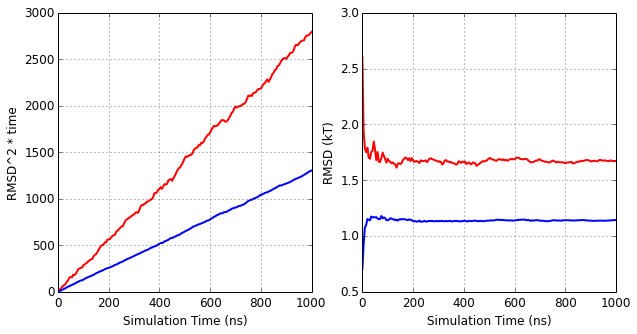

In [142]:

%matplotlib inline 
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.rcParams.update({'font.size': 12})
 
axes = fig.add_subplot(121)
axes.grid()
axes.plot(np.arange(0,np.size(RMSD))*5,np.power(RMSD/kt,2)*np.arange(0,np.size(RMSD))*5,label='KLDIV',color='red',lw=2)
axes.plot(np.arange(0,np.size(RMSD2))*5,np.power(RMSD2/kt,2)*np.arange(0,np.size(RMSD2))*5,label='RMSDcut',color='blue',lw=2)


axes.set_xlabel('Simulation Time (ns)')
axes.set_ylabel('RMSD^2 * time ')

axes2 = fig.add_subplot(122)
axes2.grid()
axes2.plot(np.arange(0,np.size(RMSD))*5,RMSD/kt,label='KLDIV',color='red',lw=2)
axes2.plot(np.arange(0,np.size(RMSD2))*5,RMSD2/kt,label='RMSDcut',color='blue',lw=2)


axes2.set_xlabel('Simulation Time (ns)')
axes2.set_ylabel('RMSD (kT) ')

#axes.set_ylim([0,10])
#axes.set_xlim([0,500])
plt.rcParams.update({'font.size': 12})

plt.show()



In [4]:

# phi1 phi2


# phi psi theta zeta vbias phi psi  ctbest
#  0   1    2    3    4     5    6    7
data=np.genfromtxt('ALA2/PBMetad-2D/rewfile_new',comments='#')
#make 2D histogram then replace all zeros with 1e-100

In [ ]:
# read in CV1 CV2 pb.bias 
data=np.genfromtxt('ALA2/PBMetad-2D/rewfile_new',comments='#')
# 
# 
hist, xedges, yedges = np.histogram2d(data[0:stop,0],data[0:stop,1], \
                            bins=bins,normed=True,weights=np.exp(beta*(data[0:stop,4])

In [31]:
kt=300.0*8.314e-3
beta=1/kt
nu=8.314e-3*300.0*8 #about 15 kJ/mol 
fill=1000.0
bins=50
method='cubic'
points=100

RMSDCT1=np.array([])

fesdata2 = np.genfromtxt('ALA2/WTM-2/fes.dat.100',comments='#');
fesdata2 = fesdata2[:,0:3]
gX, gY = np.mgrid[-3.0:3.0:50j, -3.0:3.0:50j ]
Z2new=griddata(fesdata2[:,:2],fesdata2[:,2],(gX, gY),method=method,fill_value=1000)


for k in np.arange(np.shape(data)[0]/points,np.shape(data)[0],np.shape(data)[0]/points):
    stop=k.astype(int)
    hist, xedges, yedges = np.histogram2d(data[0:stop,0],data[0:stop,1], \
                                             bins=bins,normed=True,weights=np.exp(beta*(data[0:stop,4]-350-data[0:stop,5])))

    # this makes a very small prob = very high free-energy (40kT)
    hist[hist == 0 ] = 1e-100
    hist=(1/beta)*-1.0*np.log(hist)
    dum=np.reshape(hist,-1)
    val=0
    Zmake=np.zeros((2500,3))
    for i in np.nditer(np.r_[0.5 * (xedges[:-1] + xedges[1:])]):
        for j in np.nditer(np.r_[0.5 * (yedges[:-1] + yedges[1:])]):
            Zmake[val,:]=[i,j,dum[val]]
            val=val+1


    hist=griddata(Zmake[:,:2],Zmake[:,2],(gX, gY),method=method,fill_value=1000)
    var=RMSDall(hist,Z2new,kt,nu) 
    RMSDCT1=np.append(RMSDCT1,var[1])   

    
    

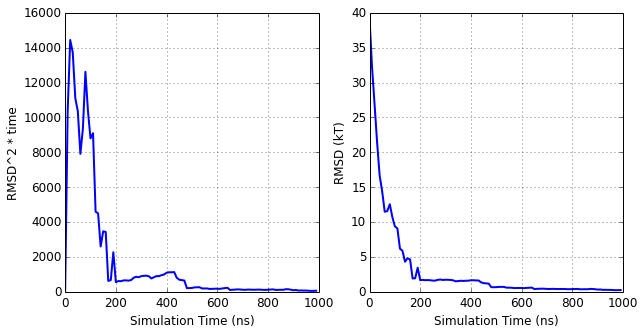

In [32]:

%matplotlib inline 
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.rcParams.update({'font.size': 12})
plot=RMSDCT1
axes = fig.add_subplot(121)
axes.grid()
axes.plot(np.arange(0,np.size(plot))*10,np.power(plot/kt,2)*np.arange(0,np.size(plot))*10,label='CUT',color='blue',lw=2)

axes.set_xlabel('Simulation Time (ns)')
axes.set_ylabel('RMSD^2 * time ')

axes2 = fig.add_subplot(122)
axes2.grid()
axes2.plot(np.arange(0,np.size(plot))*10,plot/kt,label='CUT',color='blue',lw=2)


axes2.set_xlabel('Simulation Time (ns)')
axes2.set_ylabel('RMSD (kT) ')

#axes.set_ylim([0,10])
#axes.set_xlim([0,500])
plt.rcParams.update({'font.size': 12})

plt.show()




In [33]:
kt=300.0*8.314e-3
beta=1/kt
#nu=8.314e-3*300.0*6 #about 15 kJ/mol 
fill=1000.0
bins=50
method='cubic'
points=100 

RMSDCT2=np.array([])

fesdata2 = np.genfromtxt('ALA2/WTM-2/fes.dat.100',comments='#');
fesdata2 = fesdata2[:,0:3]
gX, gY = np.mgrid[-3.0:3.0:50j, -3.0:3.0:50j ]
Z2new=griddata(fesdata2[:,:2],fesdata2[:,2],(gX, gY),method=method,fill_value=1000)

# %reset_selective stop hist, xedges, yedges, dum, val, Zmake var 



for k in np.arange(np.shape(data)[0]/points,np.shape(data)[0],np.shape(data)[0]/points):
    stop=k.astype(int)
    hist, xedges, yedges = np.histogram2d(data[0:stop,0],data[0:stop,1], \
                                             bins=bins,normed=True,weights=np.exp(beta*(data[0:stop,4]-350-data[0:stop,5])))

    # this makes a very small prob = very high free-energy (40kT)
    hist[hist == 0 ] = 1e-100
    hist=(1/beta)*-1.0*np.log(hist)
    dum=np.reshape(hist,-1)
    val=0
    Zmake=np.zeros((2500,3))
    for i in np.nditer(np.r_[0.5 * (xedges[:-1] + xedges[1:])]):
        for j in np.nditer(np.r_[0.5 * (yedges[:-1] + yedges[1:])]):
            Zmake[val,:]=[i,j,dum[val]]
            val=val+1


    hist=griddata(Zmake[:,:2],Zmake[:,2],(gX, gY),method=method,fill_value=1000)
    var=RMSDall(hist,Z2new,kt,nu) 
    RMSDCT2=np.append(RMSDCT2,var[1])   

    
    

In [34]:
kt=300.0*8.314e-3
beta=1/kt
#nu=8.314e-3*300.0*6 #about 15 kJ/mol 
fill=1000.0
bins=50
method='cubic'
points=100

RMSDCT3=np.array([])

fesdata2 = np.genfromtxt('ALA2/WTM-2/fes.dat.100',comments='#');
fesdata2 = fesdata2[:,0:3]
gX, gY = np.mgrid[-3.0:3.0:50j, -3.0:3.0:50j ]
Z2new=griddata(fesdata2[:,:2],fesdata2[:,2],(gX, gY),method=method,fill_value=1000)
#%reset_selective stop hist, xedges, yedges, dum, val, Zmake var 


for k in np.arange(np.shape(data)[0]/points,np.shape(data)[0],np.shape(data)[0]/points):
    stop=k.astype(int)
    #ctbest=0.5*(np.exp(data[0:stop,5]*beta/10.0)+np.exp(data[0:stop,6]*beta/10.0))
    #ctbest=np.log(ctbest)/beta
    #print np.size(ctbest)
    hist, xedges, yedges = np.histogram2d(data[0:stop,0],data[0:stop,1], \
                                             bins=bins,normed=True,weights=np.exp(beta*(data[0:stop,4]-350-data[0:stop,7])))

    # this makes a very small prob = very high free-energy (40kT)
    hist[hist == 0 ] = 1e-100
    hist=(1/beta)*-1.0*np.log(hist)
    dum=np.reshape(hist,-1)
    val=0
    Zmake=np.zeros((2500,3))
    for i in np.nditer(np.r_[0.5 * (xedges[:-1] + xedges[1:])]):
        for j in np.nditer(np.r_[0.5 * (yedges[:-1] + yedges[1:])]):
            Zmake[val,:]=[i,j,dum[val]]
            val=val+1


    hist=griddata(Zmake[:,:2],Zmake[:,2],(gX, gY),method=method,fill_value=1000)
    var=RMSDall(hist,Z2new,kt,nu) 
    RMSDCT3=np.append(RMSDCT3,var[1])   

    
    

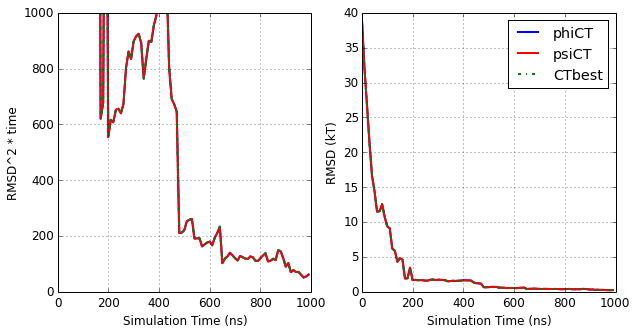

In [35]:

%matplotlib inline 
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.rcParams.update({'font.size': 12})

axes = fig.add_subplot(121)
axes.grid()
plot=RMSDCT1
axes.plot(np.arange(0,np.size(plot))*10,np.power(plot/kt,2)*np.arange(0,np.size(plot))*10,label='CT1',color='blue',lw=2)
plot=RMSDCT2
axes.plot(np.arange(0,np.size(plot))*10,np.power(plot/kt,2)*np.arange(0,np.size(plot))*10,label='CT2',color='red',lw=2)
plot=RMSDCT3
axes.plot(np.arange(0,np.size(plot))*10,np.power(plot/kt,2)*np.arange(0,np.size(plot))*10,label='CTbest',color='green',lw=2,ls='-.')

axes.set_xlabel('Simulation Time (ns)')
axes.set_ylabel('RMSD^2 * time ')

axes2 = fig.add_subplot(122)
axes2.grid()
plot=RMSDCT1
axes2.plot(np.arange(0,np.size(plot))*10,plot/kt,label='phiCT',color='blue',lw=2)
plot=RMSDCT2
axes2.plot(np.arange(0,np.size(plot))*10,plot/kt,label='psiCT',color='red',lw=2)
plot=RMSDCT3
axes2.plot(np.arange(0,np.size(plot))*10,plot/kt,label='CTbest',color='green',lw=2,ls='-.')

axes2.set_xlabel('Simulation Time (ns)')
axes2.set_ylabel('RMSD (kT) ')

#axes2.set_ylim([0,10])
axes2.set_xlim([0,1000])
axes.set_ylim([0,1000])


plt.rcParams.update({'font.size': 12})
plt.legend()
plt.show()





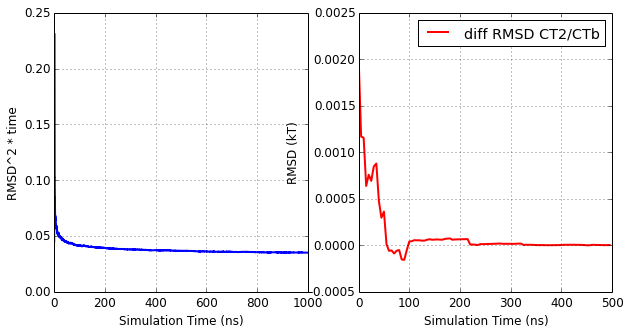

In [54]:

%matplotlib inline 
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.rcParams.update({'font.size': 12})

axes = fig.add_subplot(121)
axes.grid()
plot=data[::1000,6]-data[::1000,7]
axes.plot(np.arange(0,np.size(plot))*0.2,plot,label='CT1',color='blue',lw=2)
#plot=RMSDCT2
#axes.plot(np.arange(0,np.size(plot))*10,np.power(plot/kt,2)*np.arange(0,np.size(plot))*10,label='CT2',color='red',lw=2)
#plot=RMSDCT3
#axes.plot(np.arange(0,np.size(plot))*10,np.power(plot/kt,2)*np.arange(0,np.size(plot))*10,label='CTbest',color='green',lw=2)

axes.set_xlabel('Simulation Time (ns)')
axes.set_ylabel('RMSD^2 * time ')

axes2 = fig.add_subplot(122)
axes2.grid()
plot=RMSDCT1-RMSDCT2
#axes2.plot(np.arange(0,np.size(plot))*5,plot/kt,label='diff RMSD CT1/CT2',color='blue',lw=2)
plot=RMSDCT2-RMSDCT3
axes2.plot(np.arange(0,np.size(plot))*5,plot/kt,label='diff RMSD CT2/CTb',color='red',lw=2)
#plot=RMSDCT2
#axes2.plot(np.arange(0,np.size(plot))*5,plot/kt,label='CT2',color='red',lw=2)
#plot=RMSDCT3
#axes2.plot(np.arange(0,np.size(plot))*5,plot/kt,label='CTbest',color='green',lw=2,ls='-.')

axes2.set_xlabel('Simulation Time (ns)')
axes2.set_ylabel('RMSD (kT) ')

#axes2.set_ylim([0,10])
axes2.set_xlim([0,500])
#axes.set_xlim([0,500])
plt.rcParams.update({'font.size': 12})
plt.legend()
plt.show()






In [27]:
kt=300.0*8.314e-3
beta=1/kt
nu=8.314e-3*300.0*8 #about 15 kJ/mol 
fill=1000.0
bins=50
method='cubic'
points=10 

fesdata2 = np.genfromtxt('ALA2/WTM-2/fes.dat.100',comments='#');
fesdata2 = fesdata2[:,0:3]
gX, gY = np.mgrid[-3.0:3.0:50j, -3.0:3.0:50j ]
Z2new=griddata(fesdata2[:,:2],fesdata2[:,2],(gX, gY),method=method,fill_value=1000)

stop=np.size(data)
hist, xedges, yedges = np.histogram2d(data[0:stop,0],data[0:stop,1], \
                                             bins=bins,normed=True,weights=np.exp(beta*(data[0:stop,4]-data[0:stop,5])))

    # this makes a very small prob = very high free-energy (40kT)
hist[hist == 0 ] = 1e-100
hist=(1/beta)*-1.0*np.log(hist)
dum=np.reshape(hist,-1)
val=0
Zmake=np.zeros((2500,3))
for i in np.nditer(np.r_[0.5 * (xedges[:-1] + xedges[1:])]):
    for j in np.nditer(np.r_[0.5 * (yedges[:-1] + yedges[1:])]):
        Zmake[val,:]=[i,j,dum[val]]
        val=val+1

hist=griddata(Zmake[:,:2],Zmake[:,2],(gX, gY),method=method,fill_value=1000)



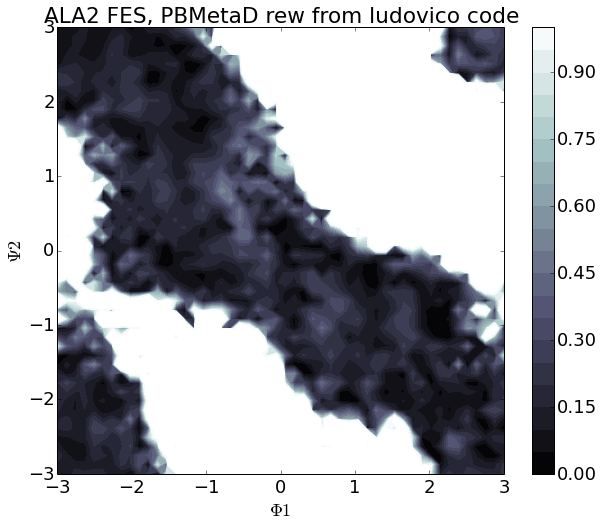

In [31]:
%matplotlib inline
#ang1wt1=np.transpose(ang1wt1)
#what spacing do you want?  
spacer=.05
lines=20 #this goes to kt 
levels=np.linspace(0,lines*spacer,num=(lines+1),endpoint=True)

fig=plt.figure(figsize=(10,8)) 
axes = fig.add_subplot(111)

#plt.contourf(xedges[1::], yedges[1::],np.transpose(np.abs(ang1wt1))/kt ,levels, cmap=plt.cm.bone,)
plt.contourf(gX,gY,np.abs(Z2new-hist)/kt,levels,cmap=plt.cm.bone,)
plt.colorbar()
plt.xlabel('$\Phi 1$')
plt.ylabel('$\Psi 2$')
plt.title('ALA2 FES, PBMetaD rew from ludovico code ')
#axes.set_ylim([.1,.5])

#axes.set_xlim([0.1,0.5])
plt.rcParams.update({'font.size': 18})
plt.show()

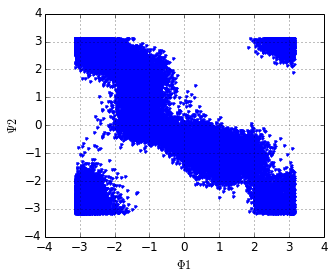

In [137]:

%matplotlib inline 
fig = plt.figure(figsize=(5,4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.rcParams.update({'font.size': 12})

axes = fig.add_subplot(111)
axes.grid()
axes.plot(data[::100,0],data[::100,1],'.')

plt.xlabel('$\Phi 1$')
plt.ylabel('$\Psi 2$')


#axes.set_ylim([0,10])
#axes.set_xlim([0,500])
plt.rcParams.update({'font.size': 12})
plt.legend()
plt.show()



In [42]:

# phi1 phi2


#! FIELDS time phi psi theta zeta metad.bias     
#make 2D histogram then replace all zeros with 1e-100
data=np.genfromtxt('/Users/jpfaendt/Modeling/PBMetaD/props/PBMeta-props/2D_histos/ALA2/COLVAR_rerurn',comments='#')


In [43]:
kt=300.0*8.314e-3
beta=1/kt
nu=8.314e-3*300.0*8 #about 15 kJ/mol 
fill=1000.0
bins=50
method='cubic'
points=200 

RMSDCT1=np.array([])

fesdata2 = np.genfromtxt('ALA2/WTM-2/fes.dat.100',comments='#');
fesdata2 = fesdata2[:,0:3]
gX, gY = np.mgrid[-3.0:3.0:50j, -3.0:3.0:50j ]
Z2new=griddata(fesdata2[:,:2],fesdata2[:,2],(gX, gY),method=method,fill_value=1000)

for k in np.arange(np.shape(data)[0]/points,np.shape(data)[0],np.shape(data)[0]/points):
    stop=k.astype(int)
    hist, xedges, yedges = np.histogram2d(data[0:stop,1],data[0:stop,2], \
                                             bins=bins,normed=True,weights=np.exp(beta*(data[0:stop,5])))

    # this makes a very small prob = very high free-energy (40kT)
    hist[hist == 0 ] = 1e-100
    hist=(1/beta)*-1.0*np.log(hist)
    dum=np.reshape(hist,-1)
    val=0
    Zmake=np.zeros((2500,3))
    for i in np.nditer(np.r_[0.5 * (xedges[:-1] + xedges[1:])]):
        for j in np.nditer(np.r_[0.5 * (yedges[:-1] + yedges[1:])]):
            Zmake[val,:]=[i,j,dum[val]]
            val=val+1


    hist=griddata(Zmake[:,:2],Zmake[:,2],(gX, gY),method=method,fill_value=1000)
    var=RMSDallnomean(hist,Z2new,kt,nu) 
    print var 
    RMSDCT1=np.append(RMSDCT1,var[1])   

    
    

[44.638115969381857, 229.75979788050913]
[31.397538726171447, 198.86986247836839]
[23.464469673458094, 169.21142613514434]
[22.716378602112286, 159.87231795138078]
[19.734904714922635, 145.164803030234]
[18.179875921928843, 137.22690698472263]
[17.960825244486298, 130.96601344902905]
[17.228576462425785, 127.46461004706218]
[16.137630939851682, 120.4777889912492]
[14.238185479672236, 115.87343315572723]
[12.956601658861324, 106.35969121015124]
[12.611368697916117, 103.05213125106124]
[12.504039695474031, 100.05464582647198]
[11.813585478131969, 94.126381985528127]
[11.264426811324853, 89.425468888519092]
[10.907350972378506, 86.862119235459005]
[10.484902712588147, 81.268163349875152]
[10.412007485340121, 81.119061888002676]
[9.6769831136823417, 75.160380467994955]
[9.6098531952552726, 71.493070108917607]
[9.5643956124912552, 71.638081006358632]
[9.1748607563725031, 68.695885202218278]
[9.1583543746884324, 68.69937228811402]
[9.1012739349667591, 68.685787508661932]
[8.6469739962299759,

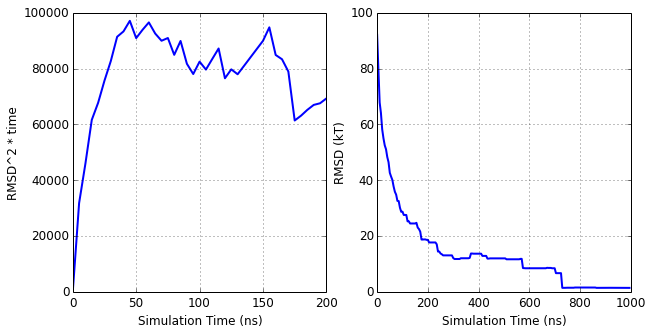

In [46]:

%matplotlib inline 
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.rcParams.update({'font.size': 12})
plot=RMSDCT1
axes = fig.add_subplot(121)
axes.grid()
axes.plot(np.arange(0,np.size(plot))*5,np.power(plot/kt,2)*np.arange(0,np.size(plot))*5,label='CUT',color='blue',lw=2)

axes.set_xlabel('Simulation Time (ns)')
axes.set_ylabel('RMSD^2 * time ')

axes2 = fig.add_subplot(122)
axes2.grid()
axes2.plot(np.arange(0,np.size(plot))*5,plot/kt,label='CUT',color='blue',lw=2)


axes2.set_xlabel('Simulation Time (ns)')
axes2.set_ylabel('RMSD (kT) ')

#axes.set_ylim([0,60])
axes.set_xlim([0,200])
plt.rcParams.update({'font.size': 12})

plt.show()





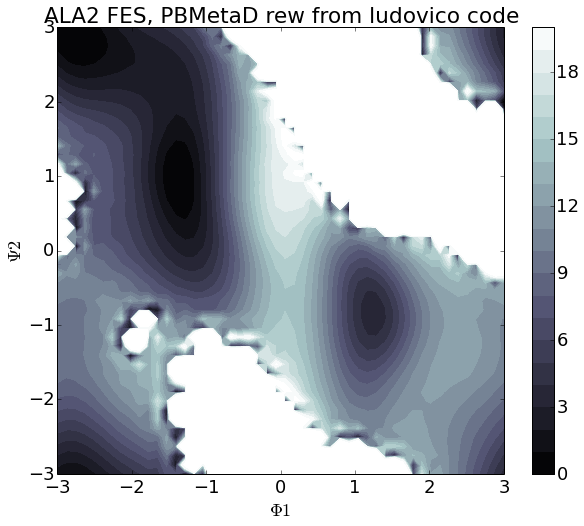

In [7]:
%matplotlib inline
#ang1wt1=np.transpose(ang1wt1)
#what spacing do you want?  
spacer=1
lines=20 #this goes to kt 
levels=np.linspace(0,lines*spacer,num=(lines+1),endpoint=True)

fig=plt.figure(figsize=(10,8)) 
axes = fig.add_subplot(111)

#plt.contourf(xedges[1::], yedges[1::],np.transpose(np.abs(ang1wt1))/kt ,levels, cmap=plt.cm.bone,)
plt.contourf(gX,gY,np.abs(hist)/kt,levels,cmap=plt.cm.bone,)
plt.colorbar()
plt.xlabel('$\Phi 1$')
plt.ylabel('$\Psi 2$')
plt.title('ALA2 FES, PBMetaD rew from ludovico code ')
#axes.set_ylim([.1,.5])

#axes.set_xlim([0.1,0.5])
plt.rcParams.update({'font.size': 18})
plt.show()

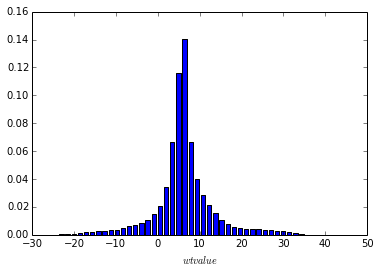

In [58]:

# phi psi theta zeta vbias phi1 phi10 psi1 psi10
#  0   1    2    3    4     5    6     7  8   

%matplotlib inline
beta=1/8.314e-3/300
hist1, bins1 = np.histogram((data[:,4]-data[:,5]), bins=50,normed=True)
width = 0.7 * (bins1[1] - bins1[0])
center = (bins1[:-1] + bins1[1:]) / 2

fig = plt.figure(figsize=(6,4))


plt.bar(center, hist1, align='center', width=width)

plt.xlabel('$wt value$')


plt.show()